In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import matplotlib.pyplot as plt

import inference
from inference.distribution import Gaussian, GaussianMixture
from inference.sde import OU, EulerMaruyamaSimulator, LangevinDynamics

In [ ]:
import torch
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from inference.distribution import Density
from inference.simulator import Simulator

def plot_trajectories_1d(x0: torch.Tensor, simulator, timesteps: torch.Tensor, true_density: Density):
    fig = plt.figure(figsize=(10, 6))
    gs = GridSpec(1, 4, width_ratios=[4, 0.15, 0.05, 1], wspace=0.05)  # <-- tighter spacing
    alpha = 0.3

    ax_main = fig.add_subplot(gs[0])
    ax_main.set_title('Trajectories')
    ax_main.set_xlabel(r'Time ($t$)', fontsize=14)
    ax_main.set_ylabel(r'$X_t$', fontsize=14)
    ax_main.grid(True)

    trajectories = simulator.simulate_with_trajectory(x0, timesteps)
    final_values = trajectories[:, -1, 0].detach().cpu().numpy()

    for i in range(trajectories.shape[0]):
        ax_main.plot(timesteps.cpu(), trajectories[i, :, 0].detach().cpu(), alpha=alpha)

    ax_hist = fig.add_subplot(gs[3], sharey=ax_main)
    ax_hist.set_title('Final Distribution')
    ax_hist.hist(final_values, bins=40, orientation='horizontal', density=True, color='gray', alpha=0.7)
    ax_hist.tick_params(labelleft=False)
    ax_hist.set_xlabel('Freq', fontsize=12)

    y_min, y_max = ax_main.get_ylim()
    y_vals = torch.linspace(y_min, y_max, 500).unsqueeze(1)
    with torch.no_grad():
        log_probs = true_density.log_density(y_vals)
        probs = torch.exp(log_probs).squeeze().cpu().numpy()

    ax_hist.plot(probs, y_vals.squeeze().cpu().numpy(), 'r--', linewidth=2, label='Theoretical PDF')

    plt.tight_layout()


# Testing

### SDE Solver

100%|██████████| 999/999 [00:00<00:00, 14117.95it/s]
/var/folders/wd/zr_by8q96891mxc_506sm9sr0000gn/T/ipykernel_58704/4053835681.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


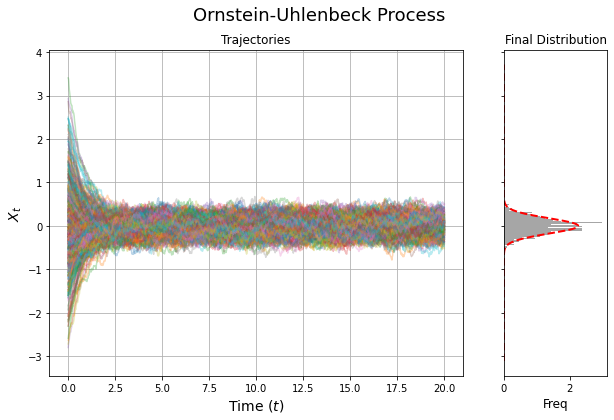

In [39]:
theta = 1.0
sigma = 0.25
sde = OU(theta=theta, sigma=sigma)
simulator = EulerMaruyamaSimulator(sde=sde)
true_density = Gaussian(
    mean = torch.tensor([0.0]), 
    cov = sigma**2 / (2 * theta) * torch.eye(1) # Limiting distribution from OU process
)

# Simulator Settings
num_trials = 500
num_steps = 1000
tf = 20.0

x0 = torch.randn((num_trials,1))
ts = torch.linspace(0, tf, num_steps)

# Visualization
plot_trajectories_1d(x0=x0, simulator=simulator, timesteps=ts, true_density=true_density)
plt.suptitle('Ornstein-Uhlenbeck Process', fontsize=18)
plt.show()

# Langevin Simulator

100%|██████████| 1999/1999 [00:02<00:00, 811.21it/s]
/var/folders/wd/zr_by8q96891mxc_506sm9sr0000gn/T/ipykernel_58704/4053835681.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


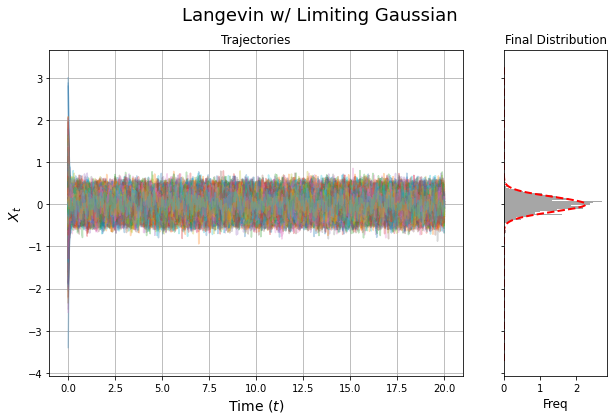

In [50]:
true_density = Gaussian(
    mean = torch.tensor([0.0]), 
    cov = sigma**2 / (2 * theta) * torch.eye(1) # Limiting distribution from OU process
)
sde = LangevinDynamics(
    score=true_density.score, 
    noise_scheduler=inference.scheduler.sigmoid
)
simulator = EulerMaruyamaSimulator(sde = sde)

# Simulator Settings
num_trials = 500
num_steps = 2000
tf = 20.0

x0 = torch.randn((num_trials,1))
ts = torch.linspace(0, tf, num_steps)

# Visualization
plot_trajectories_1d(x0=x0, simulator=simulator, timesteps=ts, true_density=true_density)
plt.suptitle('Langevin w/ Limiting Gaussian', fontsize=18)
plt.show()